In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
from datetime import datetime
from pathlib import Path
from ipynb.fs.defs.Prepare_Data import train_test_val
from ipynb.fs.defs.Feature_Engineering import add_new_features
from ipynb.fs.defs.Feature_Engineering import preprocess_dataset
from ipynb.fs.defs.Data_Augmentation import data_augmentation

In [2]:
# Loading and preprocessing the data
df = pd.read_excel('../data/labeled_data/G65_labeled.xlsx',index_col=0)
df_new_features = add_new_features(df)
df_preprocessed, df_for_plot = preprocess_dataset(df_new_features)

2023-05-03 17:24:49.313 | INFO     | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:12 - Start preprocessing the dataframe with 4585 samples...
2023-05-03 17:24:49.328 | SUCCESS  | ipynb.fs.defs.Feature_Engineering:preprocess_dataset:40 - The dataset is successfully preprocessed. The new dataset contains 854 samples


In [3]:
# Declare which data augmentation techniques should be used
rand_order = True
rand_mistakes = True
gpt = True

# Generate the new dataset
df_new = data_augmentation(df_preprocessed, rand_order, rand_mistakes, gpt, df_to_excel = False)

2023-05-03 17:24:55.929 | INFO     | ipynb.fs.defs.Data_Augmentation:data_augmentation:194 - Start adding artificial designations...
2023-05-03 17:25:16.184 | SUCCESS  | ipynb.fs.defs.Data_Augmentation:data_augmentation:237 - Creating a new dataset with artificial designations was succeccfull!


In [13]:
dateTimeObj = datetime.now()
timestamp = dateTimeObj.strftime("%d%m%Y_%H%M")

In [14]:
# Split dataset
X_train, y_train, X_val, y_val, X_test,y_test = train_test_val(df_new, test_size=0.4, timestamp=timestamp)


c:\Users\q617269\AppData\Local\anaconda3\envs\envMesstool\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[LightGBM] [Info] Number of positive: 97, number of negative: 420
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1291
[LightGBM] [Info] Number of data points in the train set: 517, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.409283 -> initscore=-0.366931
[LightGBM] [Info] Start training from score -0.366931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

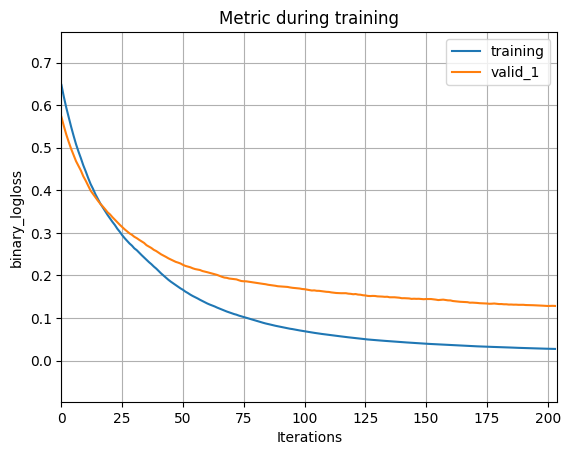

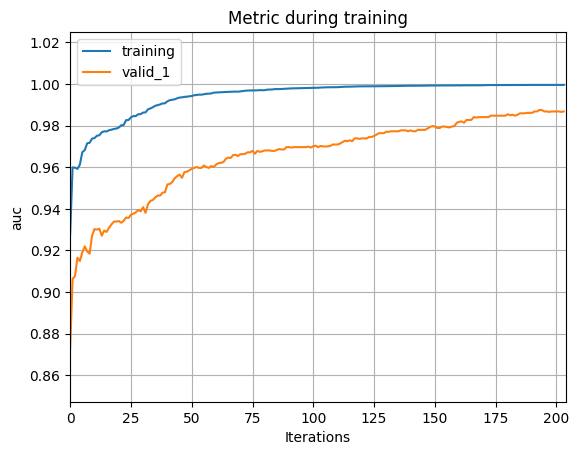

In [15]:
class_weight = {0: 1, 1: 3}

lgbm_train = lgb.Dataset(X_train, y_train, weight=y_train.map(class_weight))
lgbm_eval = lgb.Dataset(X_val, y_val, reference=lgbm_train)

params = {
    'objective': 'binary',
    'metric': ['auc', 'binary_logloss'],
    'num_leaves': 18,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

evals = {}
callbacks = [lgb.early_stopping(10), lgb.record_evaluation(evals)]

gbm = lgb.train(params,
                lgbm_train,
                num_boost_round=300,
                valid_sets=[lgbm_train, lgbm_eval],
                callbacks=callbacks)

# save model
model_path = f"../models/lgbm_{timestamp}.pkl"
with open(model_path, "wb") as filestore:
    pickle.dump(gbm, filestore)

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration, force_row_wise=True)
y_pred = np.round(y_pred)

# Print accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("\n\n Test accuracy:", accuracy)

lgb.plot_metric(evals, metric='binary_logloss')
lgb.plot_metric(evals, metric='auc')